# 2 - Etapa de preprocesado de texto

In [1]:
import random 

import sys
sys.path.append('../..')

#from utils import load_cinema_reviews

import random
random.seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/df_train.txt")

In [4]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/df_test.txt")

Nos quedamos con las columnas que no nos interesan de los dataset ("label" y "reviewText")

In [5]:
df_train = df_train[["reviewText","label"]]
df_test = df_test[["reviewText","label"]]

### 2.1 Eliminamos las reviews con mas de 1000 palabras para que nuestro modelo generalize evitando criticas de longitud poco habitual

In [6]:
def word_counter (x):
  doc = x.split()
  return len(doc)

In [7]:
df_train["word_len"] = df_train["reviewText"].apply(lambda x: word_counter(x))
df_train = df_train[(df_train["word_len"]<1000)]

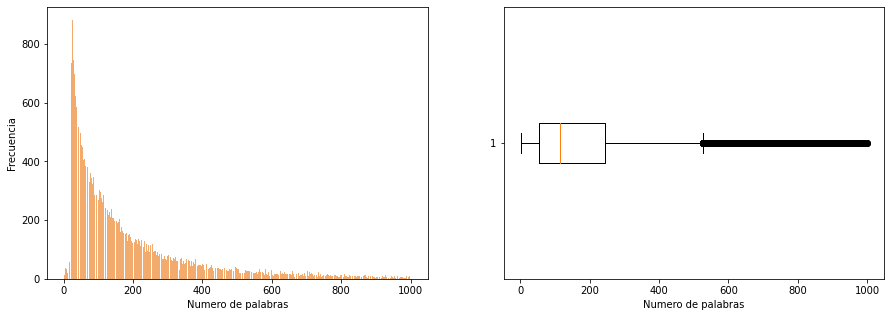

In [8]:
Len_text = df_train["reviewText"].apply(lambda x: word_counter(x))

plt.figure(figsize=(15, 5))  
plt.subplot(1,2,1)
plot.hist(x=Len_text, bins=500, color='#F2AB6D', rwidth=0.85)
plot.title('')
plot.xlabel('Numero de palabras')
plot.ylabel('Frecuencia')
#plot.xticks([0,100000])

plt.subplot(1,2,2)
plt.boxplot(Len_text, vert=False)
plt.xlabel('Numero de palabras')
print("\n")


Vemos que aun tenemos un buen numero de outliers. Habra que estudiar si ayudan a la prediccion o la perjudican

### 2.2 Hacemos una primera funcion de preprocesado y hacemos lo analogo para el dataset de test

In [9]:
def word_sentence_split(x):
  x = x.lower().split()
  x = " ".join(x)
  x = x.replace(".", ". ")
  return x

def eliminate_number(x):
  import re
  x = re.sub(r'[0-9]', ' ', x)
  return x

def filter_punctuation(x):
  import string
  for i in range(len(string.punctuation)):
    x = x.replace(string.punctuation[i], " ")
  return x

def remove_spaces(x):
  # Remove spaces at the end and beginning of the text. Removing double spaces.
  x = x.strip()
  x = x.replace("  ", " ")
  x = x.replace("  ", " ")
  " ".join(x.split())
  return x

def word_treatment(x):
  #Tokenizamos en palabras
  x = word_sentence_split(x)
  #No esperamos que los numeros tengan efecto sobre el analisis de sentimiento, asi que los eliminamos
  x = eliminate_number(x)
  # Eliminamos tambien los signos de puntuacion
  x = filter_punctuation(x)
  #Eliminamos los espacios
  x = remove_spaces(x)
  return x


In [10]:
def processing(df, pretreatment = True, Tfidf = True, cv = None, stopwords = []):
  # Normalizamos y limpiamos el corpus 
  if pretreatment == True:
    df["reviewText"] = df['reviewText'].apply(lambda x: word_treatment(x))
    print("El corpus ha sido pretratado")

  # Transformamos nuestro corpus a un vector Tfidf
  if Tfidf == True:

    if cv == None:
      cv = TfidfVectorizer(
        stop_words= stopwords,
        ngram_range=(1, 4),
        strip_accents='ascii',
        max_df=0.95,
        min_df=5,
        max_features=3000
      )
      cv.fit(df["reviewText"])
      X = cv.transform(df["reviewText"])
      print("Se ha realizado una vectorización Tfidf")
      return df, X, cv

    else:
      X = cv.transform(df["reviewText"])
      print("Se ha realizado una vectorización Tfidf basado en el corpus suministrado por cv")
    return df, X
  else:
    return df

En el ejercicio anterior se detecto una serie de palabras que tenían un chi^2 alto, y por lo tanto decisivas a la hora de clasificar la review, que no deberían implicar polaridad. Estas palabras se incluiran como stopwords

In [11]:
df_train, X_train, cv = processing(df_train, stopwords = ["ea", "drm", "money", "your money"] )

df_test, X_test = processing(df_test, cv = cv)

El corpus ha sido pretratado


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['your'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Se ha realizado una vectorización Tfidf
El corpus ha sido pretratado
Se ha realizado una vectorización Tfidf basado en el corpus suministrado por cv


In [12]:
import pickle

pickle.dump(cv, open("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/tfidf.pickle", "wb"))

### GUARDAMOS LAS VARIABLES PARA EL PROXIMO EJERCICIO

In [11]:
X_train = pd.DataFrame(X_train.toarray())
X_train.to_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/X_train.txt")


np.savetxt("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/y_train.txt", df_train["label"].to_numpy().reshape(-1,1))

X_test = pd.DataFrame(X_test.toarray())
X_test.to_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/X_test.txt")

np.savetxt("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/y_test.txt", df_test["label"].to_numpy().reshape(-1,1))

import pickle

pickle.dump(cv, open("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/tfidf.pickle", "wb"))
